In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

In [ ]:
entries = []
entry = []
urlnumber = 2 # Give the page number to start with

while len(entries) <= 5100: # Give the entry count to end with

    url = 'http://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

print ("Wrote to edmunds_extraction.csv")

## Task A

### Read in scrapped comments

In [50]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re

In [51]:
import spacy
# import spacy.cli?
# spacy.cli.download("en_core_web_sm")
from spacy.lang.en import stop_words

In [52]:
# import os
# os.chdir(r'/Users/yanhuanhuang/Desktop/MMA/INSY669-Text Analytics/Group Project/INSY669-Text-Analytics-')

In [53]:
# Documents
doc = pd.read_csv('edmunds_extraction.csv', header=None)
doc

,0,1,2
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...
1,kd6aw1,April 2002,Have found out that with some of the more pow...
2,fwatson,April 2002,How does your theory explain English cars? A ...
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t..."
...,...,...,...
5145,laurasdada,May 2006,"I had a '99 300M, loved it. New 300? Well, th..."
5146,ivorypearlg,May 2006,I've been in the 300M and 300C... Much differ...
5147,shipo,May 2006,"I don't know, maybe it's just me or maybe my ..."
5148,dhanley,May 2006,"Actually, the m35x gets 17/24 mpg, same as th..."


In [54]:
# add column name
doc.columns = ["users", "time", "txt"]
doc.head()

,users,time,txt
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...
1,kd6aw1,April 2002,Have found out that with some of the more pow...
2,fwatson,April 2002,How does your theory explain English cars? A ...
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t..."


In [55]:
# tokenize and lower case
import nltk
from nltk import word_tokenize

tokens = []
for i in range(len(doc)):
    tokens.append(word_tokenize(doc.loc[i,'txt'].lower()))
doc['txt_tokenized'] = tokens

In [56]:
doc

,users,time,txt,txt_tokenized
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...,"[the, problem, is, that, they, are, huge, gene..."
1,kd6aw1,April 2002,Have found out that with some of the more pow...,"[have, found, out, that, with, some, of, the, ..."
2,fwatson,April 2002,How does your theory explain English cars? A ...,"[how, does, your, theory, explain, english, ca..."
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my...","[``, being, that, it, is, an, automatic, i, ca..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t...","[he, did, mention, ``, in, rush, hour, traffic..."
...,...,...,...,...
5145,laurasdada,May 2006,"I had a '99 300M, loved it. New 300? Well, th...","[i, had, a, '99, 300m, ,, loved, it, ., new, 3..."
5146,ivorypearlg,May 2006,I've been in the 300M and 300C... Much differ...,"[i, 've, been, in, the, 300m, and, 300c, ..., ..."
5147,shipo,May 2006,"I don't know, maybe it's just me or maybe my ...","[i, do, n't, know, ,, maybe, it, 's, just, me,..."
5148,dhanley,May 2006,"Actually, the m35x gets 17/24 mpg, same as th...","[actually, ,, the, m35x, gets, 17/24, mpg, ,, ..."


### Read in models to brands mapping csv

In [57]:
# read in brand model mapping csv
model_brand_mapping = pd.read_csv("models (2).csv", header = None)
model_brand_mapping.columns = ["brand", "model"]
model_brand_mapping

,brand,model
0,acura,integra
1,acura,Legend
2,acura,vigor
3,acura,rlx
4,acura,ILX
...,...,...
523,volvo,xc90
524,volvo,s60
525,volvo,s80
526,volvo,v60


In [58]:
extra_mapping = [{'brand': 'acura', 'model': 'tl'},
 {'brand': 'acura', 'model': 'tlx'},
 {'brand': 'acura', 'model': 'tlxs'},
 {'brand': 'alfaromeo', 'model': 'alfa'},
 {'brand': 'alfaromeo', 'model': 'giulia'},
 {'brand': 'audi', 'model': 'b8'},
 {'brand': 'audi', 'model': 'rs3'},
 {'brand': 'audi', 'model': 'rs4'},
 {'brand': 'audi', 'model': 'rs7'},
 {'brand': 'audi', 'model': 'rsq3'},
 {'brand': 'audi', 'model': 'rsq5'},
 {'brand': 'audi', 'model': 's3'},
 {'brand': 'audi', 'model': 's4'},
 {'brand': 'audi', 'model': 's5'},
 {'brand': 'audi', 'model': 's6'},
 {'brand': 'audi', 'model': 's8'},
 {'brand': 'audi', 'model': 'sq3'},
 {'brand': 'audi', 'model': 'sq5'},
 {'brand': 'audi', 'model': 'tt'},
 {'brand': 'bmw', 'model': '135i'},
 {'brand': 'bmw', 'model': '3 series'},
 {'brand': 'bmw', 'model': '320'},
 {'brand': 'bmw', 'model': '320i'},
 {'brand': 'bmw', 'model': '320xi'},
 {'brand': 'bmw', 'model': '325i'},
 {'brand': 'bmw', 'model': '328'},
 {'brand': 'bmw', 'model': '328 wagon'},
 {'brand': 'bmw', 'model': '328d'},
 {'brand': 'bmw', 'model': '328xd'},
 {'brand': 'bmw', 'model': '328xi'},
 {'brand': 'bmw', 'model': '330'},
 {'brand': 'bmw', 'model': '330i'},
 {'brand': 'bmw', 'model': '335'},
 {'brand': 'bmw', 'model': '335is'},
 {'brand': 'bmw', 'model': '335xi'},
 {'brand': 'bmw', 'model': '340i'},
 {'brand': 'bmw', 'model': '430'},
 {'brand': 'bmw', 'model': '435i'},
 {'brand': 'bmw', 'model': '440'},
 {'brand': 'bmw', 'model': '440i'},
 {'brand': 'bmw', 'model': '530i'},
 {'brand': 'bmw', 'model': '535d'},
 {'brand': 'bmw', 'model': '550i'},
 {'brand': 'bmw', 'model': 'e36'},
 {'brand': 'bmw', 'model': 'e39'},
 {'brand': 'bmw', 'model': 'e46'},
 {'brand': 'bmw', 'model': 'e83'},
 {'brand': 'bmw', 'model': 'e90'},
 {'brand': 'bmw', 'model': 'e90s'},
 {'brand': 'bmw', 'model': 'e91'},
 {'brand': 'bmw', 'model': 'e92'},
 {'brand': 'bmw', 'model': 'f10'},
 {'brand': 'bmw', 'model': 'f30'},
 {'brand': 'bmw', 'model': 'm2'},
 {'brand': 'bmw', 'model': 'm235'},
 {'brand': 'bmw', 'model': 'm235i'},
 {'brand': 'bmw', 'model': 'm2c'},
 {'brand': 'bmw', 'model': 'm325i'},
 {'brand': 'bmw', 'model': 'm4'},
 {'brand': 'bmw', 'model': 'm50'},
 {'brand': 'bmw', 'model': 'x1'},
 {'brand': 'bmw', 'model': 'x3'},
 {'brand': 'bmw', 'model': 'x5'},
 {'brand': 'bmw', 'model': 'x6'},
 {'brand': 'bmw', 'model': 'zhp'},
 {'brand': 'cadillac', 'model': 'ats'},
 {'brand': 'cadillac', 'model': 'caddy'},
 {'brand': 'cadillac', 'model': "cadillac's"},
 {'brand': 'cadillac', 'model': 'xt5'},
 {'brand': 'chevrolet', 'model': 'vette'},
 {'brand': 'chrysler', 'model': '300c'},           
 {'brand': 'ford', 'model': 'gt350'},
 {'brand': 'ford', 'model': 'gt'},
 {'brand': 'hyundai', 'model': 'g70'},
 {'brand': 'hyundai', 'model': 'g80'},
 {'brand': 'infiniti', 'model': 'g35'},
 {'brand': 'infiniti', 'model': 'g37s'},
 {'brand': 'infiniti', 'model': 'g37x'},
 {'brand': 'infiniti', 'model': 'infinity'},
 {'brand': 'infiniti', 'model': 'jx'},
 {'brand': 'infiniti', 'model': 'm35x'},
 {'brand': 'infiniti', 'model': 'm37'},
 {'brand': 'infiniti', 'model': 'q40'},
 {'brand': 'infiniti', 'model': 'q50s'},
 {'brand': 'infiniti', 'model': 'qx56'},
 {'brand': 'jaguar', 'model': 'jag'},
 {'brand': 'jaguar', 'model': 'rover'},
 {'brand': 'jaguar', 'model': 'xf'},
 {'brand': 'kia', 'model': 'stinger'},
 {'brand': 'lexus', 'model': 'ct200h'},
 {'brand': 'lexus', 'model': 'es350'},
 {'brand': 'lexus', 'model': 'f-sport'},
 {'brand': 'lexus', 'model': 'gs350'},
 {'brand': 'lexus', 'model': 'lexi'},
 {'brand': 'lexus', 'model': 'nx'},
 {'brand': 'lexus', 'model': 'rx350'},
 {'brand': 'mazda', 'model': 'ms3'},
 {'brand': 'mercedes', 'model': 'amg'},
 {'brand': 'mercedes', 'model': 'c250'},
 {'brand': 'mercedes', 'model': 'c250s'},
 {'brand': 'mercedes', 'model': "c250's"},
 {'brand': 'mercedes', 'model': 'c300'},
 {'brand': 'mercedes', 'model': 'c350'},
 {'brand': 'mercedes', 'model': 'c400'},
 {'brand': 'mercedes', 'model': 'c63'},
 {'brand': 'mercedes', 'model': 'cla'},
 {'brand': 'mercedes', 'model': 'mb'},
 {'brand': 'mitsubishi', 'model': 'mitsubishi'},                
 {'brand': 'nissan', 'model': 'quest'},
 {'brand': 'nissan', 'model': 'ultima'},
 {'brand': 'porsche', 'model': 'porsche'},
 {'brand': 'saab', 'model': 'saab'},
 {'brand': 'saab', 'model': 'saabs'},
#  {'brand': 'skoda', 'model': 'skoda'},
 {'brand': 'subaru', 'model': 'b9'},
#  {'brand': 'tesla', 'model': 'tesla'},
 {'brand': 'volvo', 'model': 's60r'}]

In [59]:
extra_mapping = pd.DataFrame(extra_mapping)

In [60]:
combined_mapping = pd.concat([model_brand_mapping, extra_mapping], ignore_index=True)
combined_mapping

,brand,model
0,acura,integra
1,acura,Legend
2,acura,vigor
3,acura,rlx
4,acura,ILX
...,...,...
638,porsche,porsche
639,saab,saab
640,saab,saabs
641,subaru,b9


In [61]:
# check for duplicates
combined_mapping[combined_mapping.duplicated()].shape

(0, 2)

In [62]:
# turn df into dictionary
models = combined_mapping["model"].tolist()
brands = combined_mapping["brand"].tolist()
mapping_dict = {}

for i in range(len(models)):
    mapping_dict[models[i].lower()] = brands[i]

# mapping_dict

### Replace model in txt to brand

In [63]:
def model_to_brand(lst):
    
    new_lst = []
    for word in lst:
        new_lst.append(mapping_dict.get(word, word))
        
    return new_lst

In [64]:
doc["txt_token_mapped"] = doc["txt_tokenized"].apply(model_to_brand)
doc

,users,time,txt,txt_tokenized,txt_token_mapped
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...,"[the, problem, is, that, they, are, huge, gene...","[the, problem, is, that, they, are, huge, gene..."
1,kd6aw1,April 2002,Have found out that with some of the more pow...,"[have, found, out, that, with, some, of, the, ...","[have, found, out, that, with, some, of, the, ..."
2,fwatson,April 2002,How does your theory explain English cars? A ...,"[how, does, your, theory, explain, english, ca...","[how, does, your, theory, explain, english, ca..."
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my...","[``, being, that, it, is, an, automatic, i, ca...","[``, being, that, it, is, an, automatic, i, ca..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t...","[he, did, mention, ``, in, rush, hour, traffic...","[he, did, mention, ``, in, rush, hour, traffic..."
...,...,...,...,...,...
5145,laurasdada,May 2006,"I had a '99 300M, loved it. New 300? Well, th...","[i, had, a, '99, 300m, ,, loved, it, ., new, 3...","[i, had, a, '99, chrysler, ,, loved, it, ., ne..."
5146,ivorypearlg,May 2006,I've been in the 300M and 300C... Much differ...,"[i, 've, been, in, the, 300m, and, 300c, ..., ...","[i, 've, been, in, the, chrysler, and, chrysle..."
5147,shipo,May 2006,"I don't know, maybe it's just me or maybe my ...","[i, do, n't, know, ,, maybe, it, 's, just, me,...","[i, do, n't, know, ,, maybe, it, 's, just, me,..."
5148,dhanley,May 2006,"Actually, the m35x gets 17/24 mpg, same as th...","[actually, ,, the, m35x, gets, 17/24, mpg, ,, ...","[actually, ,, the, infiniti, gets, 17/24, mpg,..."


### Remove stopwords/punctuations

In [65]:
stop_words = list(stop_words.STOP_WORDS)
punc = ['.',',','!','?',';',':',"'","''", '"','``','(',')','[',']','{','}','-','...','–', '/','\\','&','%','$','#','@','+',
    '*','=','>','<','|','~','_']

In [66]:
def remove_stopwords(lst):
    
    tokens_wo_stopwords = []
    for word in lst:
        if word not in stop_words:
            if word not in punc:
                tokens_wo_stopwords.append(word)
    return tokens_wo_stopwords

In [67]:
doc["txt_wo_stopwords"] = doc["txt_token_mapped"].apply(remove_stopwords)

In [68]:
doc

,users,time,txt,txt_tokenized,txt_token_mapped,txt_wo_stopwords
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...,"[the, problem, is, that, they, are, huge, gene...","[the, problem, is, that, they, are, huge, gene...","[problem, huge, generalizations, talking, japa..."
1,kd6aw1,April 2002,Have found out that with some of the more pow...,"[have, found, out, that, with, some, of, the, ...","[have, found, out, that, with, some, of, the, ...","[found, powerful, car, like, infiniti, chevrol..."
2,fwatson,April 2002,How does your theory explain English cars? A ...,"[how, does, your, theory, explain, english, ca...","[how, does, your, theory, explain, english, ca...","[theory, explain, english, car, country, steep..."
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my...","[``, being, that, it, is, an, automatic, i, ca...","[``, being, that, it, is, an, automatic, i, ca...","[automatic, enjoy, coffee, shave, talk, cel, p..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t...","[he, did, mention, ``, in, rush, hour, traffic...","[he, did, mention, ``, in, rush, hour, traffic...","[mention, rush, hour, traffic, like, bumper-to..."
...,...,...,...,...,...,...
5145,laurasdada,May 2006,"I had a '99 300M, loved it. New 300? Well, th...","[i, had, a, '99, 300m, ,, loved, it, ., new, 3...","[i, had, a, '99, chrysler, ,, loved, it, ., ne...","['99, chrysler, loved, new, 300, styling, sent..."
5146,ivorypearlg,May 2006,I've been in the 300M and 300C... Much differ...,"[i, 've, been, in, the, 300m, and, 300c, ..., ...","[i, 've, been, in, the, chrysler, and, chrysle...","[chrysler, chrysler, different, car, m, drove,..."
5147,shipo,May 2006,"I don't know, maybe it's just me or maybe my ...","[i, do, n't, know, ,, maybe, it, 's, just, me,...","[i, do, n't, know, ,, maybe, it, 's, just, me,...","[know, maybe, maybe, detroit, roots, showing, ..."
5148,dhanley,May 2006,"Actually, the m35x gets 17/24 mpg, same as th...","[actually, ,, the, m35x, gets, 17/24, mpg, ,, ...","[actually, ,, the, infiniti, gets, 17/24, mpg,...","[actually, infiniti, gets, 17/24, mpg, chrysle..."


### Brand frequency

In [69]:
txt_combined = []

for i in range(len(doc)):
    txt_combined.extend(doc.loc[i, "txt_wo_stopwords"]) 

In [70]:
freq_dist = dict(nltk.FreqDist(word for word in txt_combined))
freq_dist

{'problem': 372,
 'huge': 69,
 'generalizations': 4,
 'talking': 203,
 'japanese': 196,
 'exclusivly': 1,
 'honda': 654,
 'toyota': 405,
 'subaru': 370,
 'mazda': 99,
 'isuzu': 4,
 'mitsubishi': 27,
 'daihatsu': 2,
 'suzuki': 21,
 'far': 290,
 'makes': 289,
 'culture': 5,
 'american': 139,
 'european': 88,
 'capable': 46,
 'having': 193,
 'higher': 134,
 'quality': 205,
 '70': 58,
 'car': 5916,
 'help': 99,
 'generalization': 5,
 'stop': 108,
 'brands': 89,
 'nations': 1,
 'found': 144,
 'powerful': 93,
 'like': 1835,
 'infiniti': 1922,
 'chevrolet': 184,
 'difference': 315,
 'performance': 914,
 'practical': 25,
 'standpoint': 12,
 'issue': 145,
 'faster': 180,
 'dream': 17,
 'driving': 774,
 'killing': 4,
 'getting': 324,
 'tickets': 3,
 'time': 603,
 'automatic': 226,
 'love': 268,
 'enjoy': 126,
 'coffee': 6,
 'shave': 4,
 'talk': 90,
 'cel': 3,
 'phone': 34,
 'hug': 5,
 'wife': 146,
 'rush': 18,
 'hour': 28,
 'traffic': 115,
 'feel': 419,
 'urge': 2,
 'shift': 92,
 'manumatic': 12

In [71]:
brand_dist = {}
brand_list = model_brand_mapping["brand"]

for brand in brand_list:
    brand_dist[brand] = freq_dist.get(brand, None)

In [72]:
brand_dist

{'acura': 2697,
 'audi': 988,
 'bmw': 4479,
 'buick': 29,
 'cadillac': 179,
 'car': 5916,
 'chevrolet': 184,
 'chrysler': 121,
 'dodge': 67,
 'ford': 289,
 'honda': 654,
 'hyndai kia': None,
 'hyundai': 176,
 'hyundai,': None,
 'hyundai.': None,
 'infiniti': 1922,
 'kia': 25,
 'kia,': None,
 'kia.': None,
 'lincoln': 60,
 'mazda': 99,
 'mercedes': 699,
 'mercury': 9,
 'mitsubishi': 27,
 'nissan': 483,
 'nissan.': None,
 'pontiac': 68,
 'problem': 372,
 'saturn': 12,
 'seat': 407,
 'sedan': 967,
 'subaru': 370,
 'suzuki': 21,
 'toyata': None,
 'toyota': 405,
 'volkswagen': 215,
 'volkwagen': 109,
 'volvo': 234}

In [73]:
cleaned_brands = []
freq_count = []

for key, value in brand_dist.items():
    if value is not None:
        if key not in ("car", "problem", "seat", "sedan"):
            cleaned_brands.append(key)
            freq_count.append(value)

In [74]:
brands_dist_df = pd.DataFrame({"brand": cleaned_brands,
                              "freq_count": freq_count})

In [75]:
sorted_freq_dist = brands_dist_df.sort_values("freq_count", ascending = False).reset_index(drop = True)

In [76]:
# show top 10
top10 = sorted_freq_dist.head(10)
top10

,brand,freq_count
0,bmw,4479
1,acura,2697
2,infiniti,1922
3,audi,988
4,mercedes,699
5,honda,654
6,nissan,483
7,toyota,405
8,subaru,370
9,ford,289


### Lift Matrix

In [77]:
# create brands paring
top10_brands = top10["brand"]
pairs = []

for i in range(len(top10_brands)):
    for j in range(i + 1, len(top10_brands)):
        pair = (top10_brands[i], top10_brands[j])
        pairs.append(pair)

In [78]:
# calculate presence of each pair in txt
pairs_freq_dict = {}
for pair in pairs:
    pairs_freq_dict[pair] = 0

In [79]:
txt_wo_stopwords_lst = doc["txt_wo_stopwords"].tolist()

for key, value in pairs_freq_dict.items():
    brand1 = key[0]
    brand2 = key[1]
    for lst in txt_wo_stopwords_lst:
        if brand1 in lst and brand2 in lst:
            pairs_freq_dict[key] = pairs_freq_dict[key] + 1

pairs_freq_dict

{('bmw', 'acura'): 580,
 ('bmw', 'infiniti'): 569,
 ('bmw', 'audi'): 253,
 ('bmw', 'mercedes'): 249,
 ('bmw', 'honda'): 185,
 ('bmw', 'nissan'): 118,
 ('bmw', 'toyota'): 140,
 ('bmw', 'subaru'): 90,
 ('bmw', 'ford'): 86,
 ('acura', 'infiniti'): 487,
 ('acura', 'audi'): 154,
 ('acura', 'mercedes'): 125,
 ('acura', 'honda'): 197,
 ('acura', 'nissan'): 118,
 ('acura', 'toyota'): 103,
 ('acura', 'subaru'): 66,
 ('acura', 'ford'): 48,
 ('infiniti', 'audi'): 153,
 ('infiniti', 'mercedes'): 128,
 ('infiniti', 'honda'): 123,
 ('infiniti', 'nissan'): 126,
 ('infiniti', 'toyota'): 78,
 ('infiniti', 'subaru'): 58,
 ('infiniti', 'ford'): 43,
 ('audi', 'mercedes'): 115,
 ('audi', 'honda'): 53,
 ('audi', 'nissan'): 39,
 ('audi', 'toyota'): 32,
 ('audi', 'subaru'): 30,
 ('audi', 'ford'): 28,
 ('mercedes', 'honda'): 47,
 ('mercedes', 'nissan'): 34,
 ('mercedes', 'toyota'): 49,
 ('mercedes', 'subaru'): 22,
 ('mercedes', 'ford'): 32,
 ('honda', 'nissan'): 99,
 ('honda', 'toyota'): 101,
 ('honda', 'subar

In [80]:
#lift calculation: P(AB)/(P(A)*P(B))
lift_dict = {}

top10_brands_dict = {}
for i in range(len(top10)):
    top10_brands_dict[top10["brand"][i]] = top10["freq_count"][i]

total_txt = len(doc)

for key, value in pairs_freq_dict.items():
    
    AB = value
    count_A = top10_brands_dict[key[0]]
    count_B = top10_brands_dict[key[0]]
    
    lift_dict[key] = total_txt*(AB)/(count_A*count_B)

In [81]:
lift_dict

{('bmw', 'acura'): 0.14889259450505077,
 ('bmw', 'infiniti'): 0.14606876943685151,
 ('bmw', 'audi'): 0.06494797656858249,
 ('bmw', 'mercedes'): 0.0639211310892373,
 ('bmw', 'honda'): 0.047491603419714465,
 ('bmw', 'nissan'): 0.030291941640682742,
 ('bmw', 'toyota'): 0.03593959177708122,
 ('bmw', 'subaru'): 0.023104023285266496,
 ('bmw', 'ford'): 0.02207717780592132,
 ('acura', 'infiniti'): 0.34480558947863493,
 ('acura', 'audi'): 0.10903503240186813,
 ('acura', 'mercedes'): 0.0885024613651527,
 ('acura', 'honda'): 0.13947987911148066,
 ('acura', 'nissan'): 0.08354632352870416,
 ('acura', 'toyota'): 0.07292602816488583,
 ('acura', 'subaru'): 0.046729299600800626,
 ('acura', 'ford'): 0.033984945164218634,
 ('infiniti', 'audi'): 0.21330050967980155,
 ('infiniti', 'mercedes'): 0.17844748522231763,
 ('infiniti', 'honda'): 0.17147688033082084,
 ('infiniti', 'nissan'): 0.1756592432657189,
 ('infiniti', 'toyota'): 0.10874143630734981,
 ('infiniti', 'subaru'): 0.08085901674136267,
 ('infiniti',

In [82]:
lift_df = pd.DataFrame(columns = top10_brands, index = top10_brands)

In [83]:
for key, value in lift_dict.items():
    A = key[0]
    B = key[1]
    
    lift_df.loc[A, B] = value
    lift_df.loc[B, A] = value

In [84]:
lift_df = lift_df.fillna(0)
lift_df

brand,bmw,acura,infiniti,audi,mercedes,honda,nissan,toyota,subaru,ford
brand,,,,,,,,,,
bmw,0.000000,0.148893,0.146069,0.064948,0.063921,0.047492,0.030292,0.035940,0.023104,0.022077
acura,0.148893,0.000000,0.344806,0.109035,0.088502,0.139480,0.083546,0.072926,0.046729,0.033985
infiniti,0.146069,0.344806,0.000000,0.213301,0.178447,0.171477,0.175659,0.108741,0.080859,0.059947
audi,0.064948,0.109035,0.213301,0.000000,0.606724,0.279621,0.205759,0.168828,0.158276,0.147724
mercedes,0.063921,0.088502,0.178447,0.606724,0.000000,0.495394,0.358370,0.516475,0.231887,0.337290
honda,0.047492,0.139480,0.171477,0.279621,0.495394,0.000000,1.192029,1.216111,0.325099,0.397343
nissan,0.030292,0.083546,0.175659,0.205759,0.358370,1.192029,0.000000,1.479067,0.419437,0.264907
toyota,0.035940,0.072926,0.108741,0.168828,0.516475,1.216111,1.479067,0.000000,0.565158,0.659351
subaru,0.023104,0.046729,0.080859,0.158276,0.231887,0.325099,0.419437,0.565158,0.000000,1.918554


### MDS

In [85]:
# Calculate dissimilarity matrix based on lift
dissimilarity_dict = {}

for key, value in lift_dict.items():
    dissimilarity_dict[key] = 1 / value

dissimilarity_dict

{('bmw', 'acura'): 6.716250753264144,
 ('bmw', 'infiniti'): 6.846090398757828,
 ('bmw', 'audi'): 15.396938485743888,
 ('bmw', 'mercedes'): 15.644278863024915,
 ('bmw', 'honda'): 21.05635371293624,
 ('bmw', 'nissan'): 33.01207997367122,
 ('bmw', 'toyota'): 27.824467406380027,
 ('bmw', 'subaru'): 43.28250485436894,
 ('bmw', 'ford'): 45.295644615037254,
 ('acura', 'infiniti'): 2.9001850042861985,
 ('acura', 'audi'): 9.17136426680116,
 ('acura', 'mercedes'): 11.299120776699029,
 ('acura', 'honda'): 7.169492878616135,
 ('acura', 'nissan'): 11.969407602435412,
 ('acura', 'toyota'): 13.712525214440568,
 ('acura', 'subaru'): 21.399849955869374,
 ('acura', 'ford'): 29.424793689320392,
 ('infiniti', 'audi'): 4.688221333840979,
 ('infiniti', 'mercedes'): 5.603889563106796,
 ('infiniti', 'honda'): 5.831689951850975,
 ('infiniti', 'nissan'): 5.6928401910926185,
 ('infiniti', 'toyota'): 9.19612646253423,
 ('infiniti', 'subaru'): 12.367204553063274,
 ('infiniti', 'ford'): 16.68134567622488,
 ('audi',

In [86]:
dissimilarity_df = pd.DataFrame(columns = top10_brands, index = top10_brands)

In [87]:
for key, value in dissimilarity_dict.items():
    A = key[0]
    B = key[1]
    
    dissimilarity_df.loc[A, B] = value
    dissimilarity_df.loc[B, A] = value

In [88]:
dissimilarity_df = dissimilarity_df.fillna(0)
dissimilarity_df

brand,bmw,acura,infiniti,audi,mercedes,honda,nissan,toyota,subaru,ford
brand,,,,,,,,,,
bmw,0.000000,6.716251,6.846090,15.396938,15.644279,21.056354,33.012080,27.824467,43.282505,45.295645
acura,6.716251,0.000000,2.900185,9.171364,11.299121,7.169493,11.969408,13.712525,21.399850,29.424794
infiniti,6.846090,2.900185,0.000000,4.688221,5.603890,5.831690,5.692840,9.196126,12.367205,16.681346
audi,15.396938,9.171364,4.688221,0.000000,1.648196,3.576274,4.860065,5.923204,6.318084,6.769376
mercedes,15.644279,11.299121,5.603890,1.648196,0.000000,2.018595,2.790411,1.936204,4.312454,2.964812
honda,21.056354,7.169493,5.831690,3.576274,2.018595,0.000000,0.838906,0.822294,3.075987,2.516717
nissan,33.012080,11.969408,5.692840,4.860065,2.790411,0.838906,0.000000,0.676102,2.384149,3.774903
toyota,27.824467,13.712525,9.196126,5.923204,1.936204,0.822294,0.676102,0.000000,1.769417,1.516644
subaru,43.282505,21.399850,12.367205,6.318084,4.312454,3.075987,2.384149,1.769417,0.000000,0.521226


In [89]:
dissimilarity_matrix = dissimilarity_df.values

In [90]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 42) 
# create two components for each of the feature/word we have
mds_result = mds.fit_transform(dissimilarity_matrix)

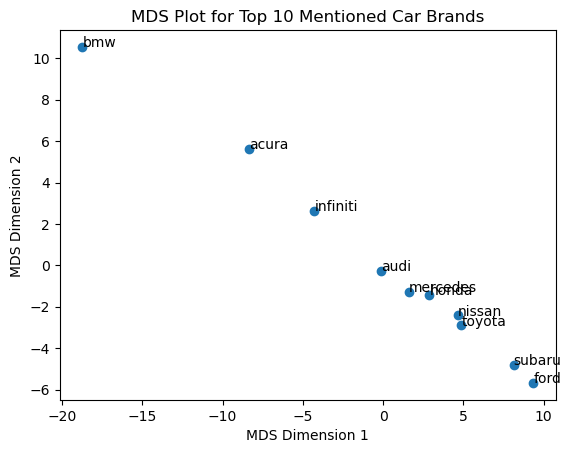

In [91]:
# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with feature names
for i, txt in enumerate(top10_brands):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot for Top 10 Mentioned Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

In [92]:
mds_result

array([[-18.73698211,  10.5527619 ],
       [ -8.32267735,   5.61186052],
       [ -4.28545042,   2.63625274],
       [ -0.14471284,  -0.28596588],
       [  1.60502604,  -1.29300626],
       [  2.88840936,  -1.4265811 ],
       [  4.65544433,  -2.41830304],
       [  4.86232844,  -2.90119668],
       [  8.12533954,  -4.79656334],
       [  9.35327501,  -5.67925886]])